### Models

In [1]:
import numpy as np
import torch
import torch.nn as nn
import os

class MLPs(nn.Module):
    def __init__(self, input_dim=2, output_dim=1, units=[4096, 4096],
                layernorm=False, dropout=None, last_activation=nn.Identity()):
        super().__init__()
        layers = []
        in_dim = input_dim
        self.layernorm = layernorm

        def block(in_, out_):
            layers = [
                nn.Linear(in_, out_),
                nn.LayerNorm(out_) if self.layernorm else nn.Identity(),
                nn.GELU(),
                nn.Dropout(dropout) if dropout else nn.Identity()
            ]
        
            return nn.Sequential(*layers)

        for out_dim in units:
            layers.extend([
                block(in_dim, out_dim)
            ])
            in_dim = out_dim
        
        layers.append(nn.Linear(in_dim, output_dim))
        layers.append(last_activation)
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# --- Log density Model ---
class ScoreOrLogDensityNetwork(nn.Module):
    def __init__(self, net, score_network=False):
        '''
        For standard MULDE use ScoreOrLogDensityNetwork(MLPs(input_dim=d+1, output_dim=1, units=[4096, 4096]))
        For MSA/NCSN use ScoreOrLogDensityNetwork(MLPs(input_dim=d+1, output_dim=d, units=[4096, 4096]), score_network=True)

        Multiscale extension to: https://github.com/Ending2015a/toy_gradlogp/tree/master

        Args:
            net (nn.Module): An log-density function, the output shape of the log-density function
                             should be (b, 1). The score is computed by grad(-log-density(x))
            score_network (bool, optional): If True, the log-density network is replaced by a score network.
                                            In this case the grad(-log-density(x)) is not computed, but the output of
                                            the network is returned. d -> d mapping instead of d -> 1. Defaults to False.
                                            This is used for the MSMA model.
        '''
        super().__init__()
        self.network = net
        self.is_score_network = score_network
    
    def forward(self, x):
        return self.network(x)
    
    def score(self, x, return_log_density=False):
        score, log_density = None, None
        if self.is_score_network:
            score = self.network(x)
            if return_log_density:
                log_density = torch.zeros_like(score[:, 0][:, None])
        else:
            x = x.requires_grad_()
            log_density = self.network(x)
            logp = -log_density.sum()
            score = torch.autograd.grad(logp, x, create_graph=True)[0] # grad(-log-density(x))
        
        if return_log_density:
            return score, log_density
        
        return score
    
    def save(self, path):
        os.makedirs(os.path.dirname(path), exist_ok= True)
        torch.save(self.state_dict(), path)
    
    def load(self, path):
        self.load_state_dict(torch.load(path))
        return self

### Utils

In [6]:
import datetime
from torch.utils.tensorboard import SummaryWriter
import glob
import pathlib
from shutil import copyfile

def get_log_path_and_summary_writer(root_dir_runs, experiment_name, postfix=None, args=None):
    now = datetime.datetime.now()
    timestamp = '_'.join(list(map(lambda x: str(x).zfill(2), [now.year, now.month, now.day, now.hour, now.minute, now.second])))
    log_path = f"{root_dir_runs}/{experiment_name}/"
    log_path += f"{timestamp}"
    if postfix is not None:
        if len(postfix) > 0:
            log_path += f"_{postfix}"
        if args.key_features.__class__ == list().__class__:
            log_path += f"_{'_'.join(args.key_features)}"
        if args.key_features.__class__ == str().__class__:
            log_path += f"_{args.key_features}"
    summary_writer = SummaryWriter(log_path)
    if args is not None:
        config_parameters = f"{'_'.join([f'{arg}_{getattr(args, arg)}' for arg in vars(args)])}"
        summary_writer.add_text('config parameters', config_parameters, 0)
    
    return log_path, summary_writer

def save_current_experiment_source_code(log_path):
    code_path = f"{log_path}/code/"
    # for search_folder, file_extension in [("", "*.py"), ("pre_processing/", "*.py"), ("models/", "*.py"), ("data/", "*.py")]:
    for search_folder, file_extension in [("", "*.py"), ("", "*.ipynb")]:
        file_names = glob.glob(os.path.join(search_folder, file_extension))
        if len(file_names) > 0:
            pathlib.Path(os.path.join(code_path, search_folder)).mkdir(parents=True, exist_ok=True)
            for file_name in file_names:
                copyfile(file_name, f"{code_path}{file_name}")

class LossAccumulate:
    def __init__(self):
        self.losses = dict()
    
    def __getitem__(self, key):
        if key not in self.losses:
            self.losses[key] = list()
        return self.losses[key]

    def __setitem__(self, key, value):
        self.losses[key] = value
    
    def items(self):
        return self.losses.items()

    def keys(self):
        return self.losses.keys()

    def values(self):
        return self.losses.values()

## Train

In [13]:
import math
from tqdm import tqdm

def get_dataset():
    def get_toy_dataset(n_samples, anomaly_centers=False):
        z = torch.randn(n_samples, 2) # 2d
        scale_centers = 4
        sq2 = 1 / math.sqrt(2)
        centers = [(1,0), (-1, 0), (0, 1), (0, -1)]
        if anomaly_centers:
            centers = [(0.5, 0.5), (-0.5, 0.5), (0.5, -0.5), (-0.5, -0.5), (0, 0)]
            centers += [(1.7, 0), (-1.7, 0), (0, 1.7), (0, -1.7)]
        
        centers = torch.tensor([(scale_centers * x, scale_centers * y) for x, y in centers])
        return sq2 * (0.3 * z + centers[torch.randint(len(centers), size=(n_samples,))])

    N = 10000

    data_train_id = get_toy_dataset(N)
    data_test_id = get_toy_dataset(N // 2)
    data_test_ood = get_toy_dataset(N // 2, anomaly_centers=True)

    data_test = np.vstack([data_test_id, data_test_ood])
    labels_test = np.hstack([np.zeros(len(data_test_id)), np.ones(len(data_test_ood))])
    labels_test = labels_test.astype(np.uint8)

    id_to_type = {
        0:'normal',
        1:'anomaly'
    }

    return data_train_id, np.zeros((len(data_train_id))).astype(np.uint8), data_test, labels_test, id_to_type

def create_meshgrid_from_data(data, n_points=100, meshgrid_offset=1):
    x_min, x_max = data[:, 0].min() - meshgrid_offset, data[:, 0].max() + meshgrid_offset
    y_min, y_max = data[:, 1].min() - meshgrid_offset, data[:, 1].max() + meshgrid_offset
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, n_points), np.linspace(y_min, y_max, n_points))
    return xx, yy

In [11]:
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
import matplotlib.pyplot as plt

figsize = (7, 7)
edgecolors = None
linewidths = 1.
marker = "x"
# colors = ['green', 'white', 'red']
# colors = ['blue', 'white', 'yellow']
# positions = [0, 0.5, 1]
# from matplotlib.colors import LinearSegmentedColormap
# cmap_mesh = LinearSegmentedColormap.from_list('CustomRedWhiteGreen', list(zip(positions, colors)))
cmap_mesh = "viridis"  # "coolwarm"


def train_and_evaluate(args):
    data_train, labels_train, data_test, labels_test, id_to_type = get_dataset()

    data_train = torch.Tensor(data_train)
    data_test = torch.Tensor(data_test)

    data_train_mean = torch.Tensor(np.asarray([0.]))
    data_train_std = torch.Tensor(np.asarray([1.]))

    if not args.unstandardized:
        data_train_mean = data_train.mean(dim=0)
        data_train_std = data_train.std(dim=0)
    
    data_train_mean = data_train_mean.to(args.device)
    data_train_std = data_train_std.to(args.device)

    dataset_train = TensorDataset(data_train, torch.Tensor(labels_train)) # shape: [2]
    dataset_test = TensorDataset(data_test, torch.Tensor(labels_test))
    dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=args.batch_size)
    dataloader_test = DataLoader(dataset_test, shuffle=False, batch_size=args.batch_size)

    if data_train.shape[1] == 2: # 2 dim feature
        meshgrid_points = 200
        xx, yy = create_meshgrid_from_data(np.vstack([data_train, data_test]), n_points=meshgrid_points,
                                            meshgrid_offset=args.meshgrid_offset)
        
        data_manifold = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])

        dataset_manifold = TensorDataset(torch.Tensor(data_manifold), torch.Tensor(np.asarray([0] * len(data_manifold))))
        dataloader_manifold = DataLoader(dataset_manifold, shuffle=False, batch_size=args.batch_size)

    net = MLPs(input_dim=data_train.reshape(data_train.shape[0], -1).shape[1] + 1,
               units=args.units, dropout=args.dropout, layernorm=args.layernorm)
    model = ScoreOrLogDensityNetwork(net=net, score_network=False).to(args.device)

    if args.gradient_clipping:
        clip_value = args.gradient_clipping
        for p in model.parameters():
            p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))
    
    optimizer = optim.Adam(model.parameters(), lr=args.lr, betas=(0.5, 0.9))
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)
    log_path, summary_writer = get_log_path_and_summary_writer(root_dir_runs='runs',
                                                                experiment_name=args.experiment_name,
                                                                args=args)
    save_current_experiment_source_code(log_path)

    if args.plot_dataset:
        plt.figure(figsize=figsize)
        plt.scatter(data_train[:, 0], data_train[:, 1], c='blue', marker=marker,
                    label='train', edgecolors=edgecolors, linewidths=linewidths)
        data_test_id = data_test[labels_test == 0]
        data_test_ood = data_test[labels_test == 1]
        plt.scatter(data_test_id[:, 0], data_test_id[:, 1], c='green', marker=marker,
                    label='test id', edgecolors=edgecolors, linewidths=linewidths)
        plt.scatter(data_test_ood[:, 0], data_test_ood[:, 1], c='red', marker=marker,
                    label='test ood', edgecolors=edgecolors, linewidths=linewidths)
        
        plt.gca().set_aspect('equal', adjustable='box')
        plt.legend()

        summary_writer.add_figure(f'dataset', plt.gcf(), 0)
        plt.close()
    
    for epoch in range(args.epochs + 1):
        with tqdm(dataloader_train) as tepoch:
            tepoch.set_description(f"Train epoch {epoch}")
            model.train()
            loss_accumulate = 0
            loss_accumulate_train = LossAccumulate()

            for batch_idx, data in enumerate(tepoch):
                x = data[0].to(args.device)
                x = x.reshape(x.shape[0], -1)
                x = (x - data_train_mean) / (data_train_std + 1e-8)

                sigma = torch.Tensor(np.exp(np.random.uniform(np.log(args.sigma_low), np.log(args.sigma_high), x.size(0)))).unsqueeze(1).to(args.device)
                noise = torch.randn_like(x, device=args.device) * sigma # scale N(0, I) with sigma -> N(0, sigma I)

                x = x.requires_grad_()
                x_ = x + noise

                labmda_factor = (sigma ** 2).ravel()
                # stack noisy data and sigma (Conditioning)
                score_, log_density_ = model.score(torch.hstack([x_, sigma]), return_log_density=True) 
                # -1 for excluding noise dim sigma condition
                loss = torch.norm(score_[:, :-1] + noise / (sigma ** 2), dim=-1) ** 2 

                loss = labmda_factor.ravel() * loss
                loss = loss.mean() / 2.
                loss_accumulate_train['loss_dsm'].append(loss.item())

                # tracking
                score_squared_norms = (torch.norm(score_[:, :-1], dim=1) ** 2)
                loss_accumulate_train['score_norm'] += (labmda_factor * score_squared_norms).tolist()
                loss_accumulate_train['log_density'] += log_density_.ravel().tolist()

                loss_regularizer = torch.Tensor(np.asarray([0.])).to(args.device)
                if args.beta:
                    # stack clean data and sigma
                    _, log_density_noise_free = model.score(torch.hstack([x, sigma]), return_log_density=True)
                    loss_regularizer = args.beta * (log_density_noise_free ** 2).mean() / 2.
                    loss += loss_regularizer
                
                loss_accumulate_train['loss_regularizer'].append(loss_regularizer.item())
                loss_accumulate_train['loss_dsm_reg'].append(loss.item())

                optimizer.zero_grad()
                loss.backward()

                all_grads = [torch.max(param.grad).item() for param in model.parameters() if param.grad is not None]
                summary_writer.add_scalar(f'gradients/max_gradient', max(all_grads), epoch * len(tepoch) + batch_idx)
                optimizer.step()
                loss_accumulate += loss.item()

            for k
                




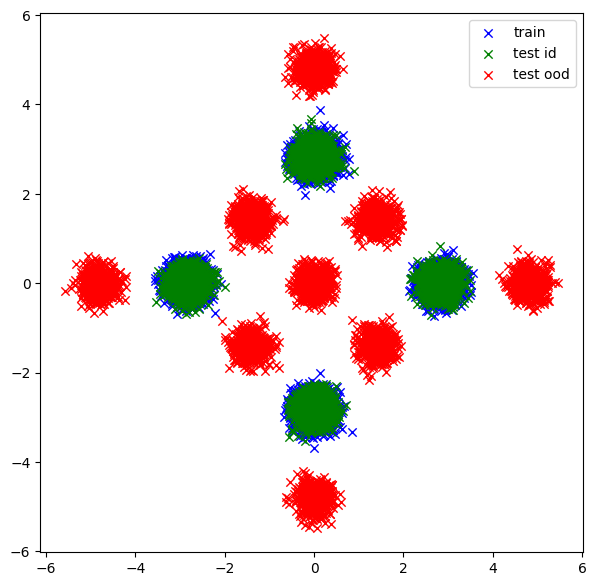

In [12]:
from argparse import Namespace

args = Namespace(
experiment_name= 'test',
device= 'mps',
epochs= 100,
lr= 5e-4,
batch_size= 2048,
units= [4096, 4096],
sigma_low= 1e-3,
sigma_high= 1.,
plot_dataset= True,
unstandardized= True,
dropout= None,
use_scheduler= True,
layernorm= True,
gmm= False,
gradient_clipping= None,
meshgrid_offset= 10.,
L= 16,
beta= None,
)
train_and_evaluate(args)

In [21]:
torch.hstack([torch.tensor([[1,2]]),
torch.tensor([[3,4]])])

tensor([[1, 2, 3, 4]])